In [16]:
library(DESeq2)
library(dplyr)
library(stringr)
library(clusterProfiler)
library(org.Hs.eg.db)
library(edgeR)
library(tidyverse)  # data manipulation
library(cluster)    # clustering algorithms
library(factoextra) 
library(pheatmap)
library(RColorBrewer)
library(ComplexHeatmap)
library(circlize)
library(DEqMS)
library(DT)
library(ggpubr)

In [17]:
library(ggrastr)

In [18]:
library(ggthemes)

In [19]:
deseq <- function(data_for_compare,coldata_for_compare){
 
    dds_compare <- DESeqDataSetFromMatrix(data_for_compare, coldata_for_compare, design= ~ group)
    #keep <- rowSums(counts(dds_compare)) >= 10
   # dds_compare <- dds_compare[keep,]
    dds_compare <- DESeq(dds_compare)
    res = results(dds_compare)
    res = res[order(res$pvalue),]
    diff_res <- subset(res, padj < 0.05 & abs(log2FoldChange) > log2(1.5))
    diff = as.data.frame(diff_res)
    allres = as.data.frame(res)

    diff_name=rownames(diff)
    all_name=rownames(allres)
    compare <- mcols(res)$description[2] %>% strsplit(split = ":") %>% .[[1]] %>% .[2]
    compare2 <- compare %>% strsplit(split=" group ") %>% .[[1]] %>% .[2] %>% strsplit(split=" vs ") %>% .[[1]]
  
    diff$category = NA
    diff[diff$log2FoldChange>0,]$category = compare2[1]
    diff[diff$log2FoldChange<0,]$category = compare2[2]
    
    allres$category = NA
    allres[allres$log2FoldChange>0,]$category = compare2[1]
    allres[allres$log2FoldChange<0,]$category = compare2[2]
    return(list(all=allres,diff=diff,dds=dds_compare))
}

In [20]:
scale_rows = function(x){
    m = apply(x, 1, mean, na.rm = T)
    s = apply(x, 1, sd, na.rm = T)
    return((x - m) / s)
}
scale_mat = function(mat, scale){
    if(!(scale %in% c("none", "row", "column"))){
        stop("scale argument shoud take values: 'none', 'row' or 'column'")
    }
    mat = switch(scale, none = mat, row = scale_rows(mat), column = t(scale_rows(t(mat))))
    return(mat)
}

In [21]:
data_Tumor_raw <- readRDS("../00.data/Tumor.raw.Rdata")

In [22]:
data_Tumor_tpm <- readRDS("../00.data/Tumor.tpm.Rdata")

## Read the Group file

In [23]:
phe <- readRDS("../00.data/phe_RNA54.Rdata")

In [24]:
head(phe)

,sample,name,ms_tumor,ms_normal,ms_ratio,status,year,group,group2,sex,age,area,smoke,alcohol,family_history,differentiation,number_of_lymph,Metastasis,TNM_stage,Stage
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>
9DW0068,9DW0068,T068,1.022,1.077,0.9489322,1,3.3260274,Low,Low_Negative,male,66,higharea,no,no,negative,NoRecord,0,negative,T3N0M0,IIA
9DW0073,9DW0073,T73,1.224,0.852,1.4366197,1,3.3479452,High,High,male,65,lowarea,no,no,negative,low,NA,NA,T4aNxM0,
9DW0074,9DW0074,T74,1.056,1.007,1.0486594,2,1.3671233,Low,Low_Negative,male,67,higharea,yes,no,negative,low,1,positive,T3N1M0,IIIB
9DW0079,9DW0079,T079,2.233,0.917,2.4351145,1,3.3095890,High,High,male,55,higharea,yes,no,positive,low,2,positive,T3N1M0,IIIB
9DW0076,9DW0076,T76,1.198,0.670,1.7880597,2,0.3917808,High,High,male,71,lowarea,yes,yes,positive,NoRecord,7,positive,T4aN3M0,IVA
9DW0085,9DW0085,T85,0.856,0.867,0.9873126,2,2.5260274,Low,Low_Negative,male,66,higharea,no,no,positive,middle,5,positive,T3N2M0,IIIB


In [25]:
group = phe[,c("sample","group")]

### convert to integer number for DEseq2 purpose

In [26]:
data_Tumor_raw <- mutate_all(data_Tumor_raw, function(x) as.integer(x))

In [27]:
data_Tumor_raw <- mutate_all(data_Tumor_raw, function(x) as.integer(x))

### remove rows where 50% of the values are zero

In [30]:
data_Tumor_raw2 <- data_Tumor_raw[rowMeans(data_Tumor_raw == 0, na.rm = TRUE) <= 0.5, ]

In [31]:
dim(data_Tumor_raw2)

[1] 19260    54

## create the group info for High vs Low, Low  vs Neg , and High vs Neg

In [32]:
coldata_High_vs_Low <- group[group$group %in% c("High","Low"),]
coldata_High_vs_Neg <- group[group$group %in% c("High","negative"),]
coldata_Low_vs_Neg <- group[group$group %in% c("Low","negative"),]

## create the group info for High vs other, Low  vs other , and negative vs other

In [33]:
coldata_High <- group
coldata_High$group <- ifelse(coldata_High$group %in% c("Low", "negative"), "rest", coldata_High$group)

In [34]:
coldata_Low <- group
coldata_Low$group <- ifelse(coldata_Low$group %in% c("High", "negative"), "rest", coldata_Low$group)

In [35]:
coldata_negative <- group
coldata_negative$group <- ifelse(coldata_negative$group %in% c("Low", "High"), "rest", coldata_negative$group)

### compare High_vs_rest, High_vs_rest, Low_vs_rest

In [36]:
data_Tumor_raw2 <- data_Tumor_raw2[,group$sample]

In [37]:
rlt_low_t <- deseq(data_Tumor_raw2,coldata_Low)
rlt_high_t <- deseq(data_Tumor_raw2,coldata_High)
rlt_neg_t <- deseq(data_Tumor_raw2,coldata_negative)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates



In [69]:
save(rlt_low_t,rlt_high_t,rlt_neg_t,file = "TumoronlyDEseq2.FC1.5.Rdata")

In [38]:
load("TumoronlyDEseq2.FC1.5.Rdata")

In [39]:
High_rlt_sig <- filter(rlt_high_t$all,padj<0.05,abs(log2FoldChange)>log2(1.5))
Low_rlt_sig <- filter(rlt_low_t$all,padj<0.05,abs(log2FoldChange)>log2(1.5))
Neg_rlt_sig <- filter(rlt_neg_t$all,padj<0.05,abs(log2FoldChange)>log2(1.5))

In [95]:
length(unique(c(rownames(High_rlt_sig),rownames(Low_rlt_sig),rownames(Neg_rlt_sig))))

[1] 531

In [89]:
High_rlt_sig %>% count(category)

category,n
<chr>,<int>
High,35
rest,25


In [90]:
Low_rlt_sig %>% count(category)

category,n
<chr>,<int>
Low,34
rest,67


In [92]:
Neg_rlt_sig %>% count(category)

category,n
<chr>,<int>
negative,89
rest,322


In [72]:
openxlsx::write.xlsx(list('High_vs_Rest' = High_rlt_sig,
                          'Low_vs_Rest' = Low_rlt_sig,
                          'Neg_vs_Rest' = Neg_rlt_sig),
           rowNames = TRUE, file = "Diffgene_TumorOnly.F1.5.xlsx")

In [201]:
rlt_neg_t$all['IL6',]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,category
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
IL6,290.4769,1.521314,0.4870165,-3.123742,0.001785671,0.05684632,negative


In [202]:
rlt_high_t$all[c('CCL8'),]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,category
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
CCL8,189.0407,-1.714634,0.4606747,3.722006,0.000197646,0.05681586,rest


In [204]:
rlt_neg_t$all['H2AX',]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,category
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
NA,NA,NA,NA,NA,NA,NA,NA


In [206]:
openxlsx::write.xlsx(list('High_vs_Rest' = rlt_high_t$all,
                          'Low_vs_Rest' = rlt_low_t$all,
                          'Neg_vs_Rest' = rlt_neg_t$all),
                          rowNames = TRUE, file = "AllDiffgene_TumorOnly.xlsx")

### volcano plot

In [45]:
plot_valcano <- function(mydata,name,gcolor){
    
    mydata$logP <- -log10(mydata$padj)
    mydata %>% mutate(group = case_when(padj<=0.05&log2FoldChange>log2(1.5) ~ name, 
                                                  padj<=0.05&log2FoldChange<(-log2(1.5)) ~ "Rest",
                                                  padj>0.05|abs(log2FoldChange)<log2(1.5) ~"NoSig" )) -> mydata
    mytable <- table(mydata$group)
    p_high <- ggscatter(mydata, x = "log2FoldChange", y = "logP", color = "group", 
            palette = c(gcolor, "#BBBBBB" ,"#2f5688"), size = 1, ## red, grey, blue
            xlab = "log2FoldChange", ylab = "-log10(Adjust P-value)",)+xlim(-3,3)+
    theme_base()+geom_hline(yintercept = -log10(0.05), linetype="dashed")+
    geom_vline(xintercept = c(-log2(1.5),log2(1.5)), linetype="dashed")+ylim(0,5)+
    annotate("text", x = 2, y = 3, label = mytable[1])+ 
    annotate("text", x = -2, y = 3, label = mytable[3])
    return(p_high)
}


In [41]:
rlt_high_t$all$log2FoldChange = -rlt_high_t$all$log2FoldChange
rlt_low_t$all$log2FoldChange = -rlt_low_t$all$log2FoldChange
rlt_neg_t$all$log2FoldChange = -rlt_neg_t$all$log2FoldChange

In [42]:
rlt_neg_t$all['IL6',]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,category
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
IL6,290.4769,1.521314,0.4870165,-3.123742,0.001785671,0.05684632,negative


In [46]:
p_high <- rasterize(plot_valcano(rlt_high_t$all,'High','#ED2224'),dpi=300)

In [47]:
p_low <- rasterize(plot_valcano(rlt_low_t$all,"Low",'#65B045'),dpi=300)

In [48]:
p_neg <- rasterize(plot_valcano(rlt_neg_t$all,"Neg",'#0B85A3'),dpi=300)

In [53]:
options(repr.plot.width =14,repr.plot.height=4)
p_volcano <- ggarrange(p_high,p_low,p_neg,ncol=3,labels = c("High_vs_Rest","Low_vs_Rest","Neg_vs_Rest"))

Warning message:
“Removed 26 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 48 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 58 rows containing missing values (`geom_point()`).”


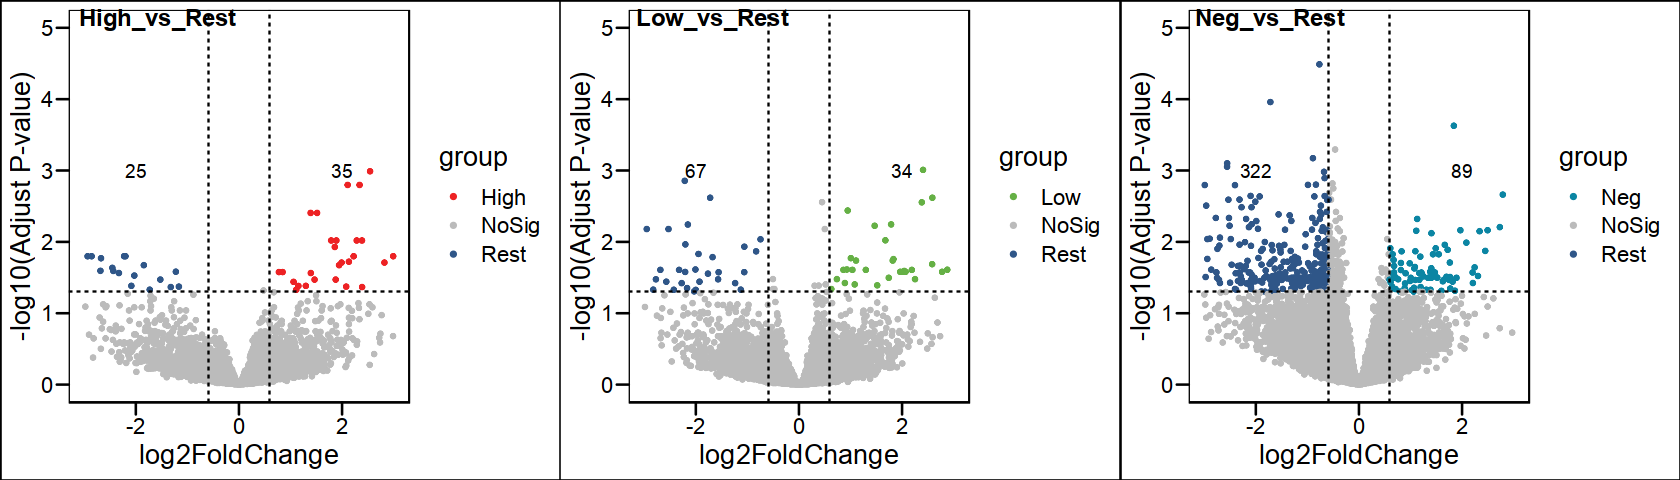

In [54]:
p_volcano

In [83]:
ggsave(filename = "TumorOnly_volcano.pdf",plot = p_volcano,width = 14,height = 4)

## merge different genes

In [56]:
diff_unique_gene_ind  <- c(High_rlt_sig %>% filter(category=="High") %>% rownames(),
                          Low_rlt_sig %>% filter(category=="Low") %>% rownames(),
                          Neg_rlt_sig %>% filter(category=="negative") %>% rownames(),
                          High_rlt_sig %>% filter(category=="rest") %>% rownames(),
                          Low_rlt_sig %>% filter(category=="rest") %>% rownames(),
                          Neg_rlt_sig %>% filter(category=="rest") %>% rownames()
                          )

### find genes from GSEA

In [57]:
load("../03.GSEA/GSEA.TumorOnly.Rdata")

In [58]:
rlt_high_t$diff -> high_spec
rlt_low_t$diff  -> low_spec
rlt_neg_t$diff  -> neg_spec

high_spec$GSEA <- NA
low_spec$GSEA <- NA
neg_spec$GSEA <- NA

In [59]:
add_genesto_diffgene <- function(high_spec,gsea_high){
    for(a in 1:nrow(high_spec)){
       temp <- gsea_high$gsea@result %>% filter(p.adjust<0.05&NES>0)
       each_gene <- high_spec %>% rownames() %>% .[a]
       add_hallmark_name <- c()
       for(b in 1:nrow(temp)){
           genes <- temp[b,'core_enrichment']%>% str_split('/') %>% .[[1]]
           hallmarks <- temp$ID[b]
           if(each_gene %in% genes){
             add_hallmark_name <-  c(add_hallmark_name,hallmarks)
           } 
       }
        add_hallmark_name2 <- paste(add_hallmark_name,collapse = ",")
        high_spec[a,'GSEA'] <- add_hallmark_name2
    }
    return(high_spec)
}

In [60]:
high_spec2 <- add_genesto_diffgene(high_spec,gsea_high_t)
low_spec2 <- add_genesto_diffgene(low_spec,gsea_low_t)
neg_spec2 <- add_genesto_diffgene(neg_spec,gsea_neg_t)

In [131]:
openxlsx::write.xlsx( list('High_spec' = high_spec2,'low_spec' = low_spec2,'neg_spec' = neg_spec2), 
               rowNames = TRUE, file = "Diffgene_TumorOnly.F1.5.addhallmark.xlsx")

## select tpm data matrix by differential genes

In [61]:
data_Tumor_tpm_diff <- data_Tumor_tpm[diff_unique_gene_ind,]

In [62]:
data_Tumor_tpm_diff[,phe %>% arrange(group) %>% rownames()] -> data_Tumor_tpm_diff2

In [63]:
data_Tumor_tpm_diff2_scale  <- scale_mat(data_Tumor_tpm_diff2 ,'row')

In [64]:
data_Tumor_tpm_diff2_scale[data_Tumor_tpm_diff2_scale>3] = 3

In [65]:
temp <- data.frame(group= c(rep("High",19),rep("Low",18),rep("Neg",17)))
temp$group <- factor(temp$group,levels=c("High","Low","Neg"))

col_fun = colorRamp2(c(min(data_Tumor_tpm_diff2_scale), 0, max(data_Tumor_tpm_diff2_scale)), 
                     c("#534ED9","white","#FF1800"))
column_ha = HeatmapAnnotation(group = c(rep("High",19),rep("Low",18),rep("Neg",17)),
                              col = list(group = c("High" = "red", "Low" = "#A65E00","Neg" = "#00733E")))
ha = rowAnnotation(foo = anno_mark(at = match(c("ERBB2","CXCR2","MYC","FOSL1","EGF","EREG","IER5",
                                                "BCL6","TNFSF4","CCNE1","HHLA2","H2AFX","TNFSF18","TRIM50"),
                                              rownames(data_Tumor_tpm_diff2)), 
    labels = c("ERBB2","CXCR2","MYC","FOSL1","EGF","EREG","IER5","BCL6","TNFSF4","CCNE1","HHLA2",
               "H2AFX","TNFSF18","TRIM50")))
p <- Heatmap(as.matrix(data_Tumor_tpm_diff2_scale), cluster_rows = FALSE,
        cluster_columns = FALSE, border = "white",gap = 1,right_annotation = ha, 
        show_row_names = F,show_column_names = F,col = col_fun,
        column_split =temp$group,
        top_annotation  = column_ha)

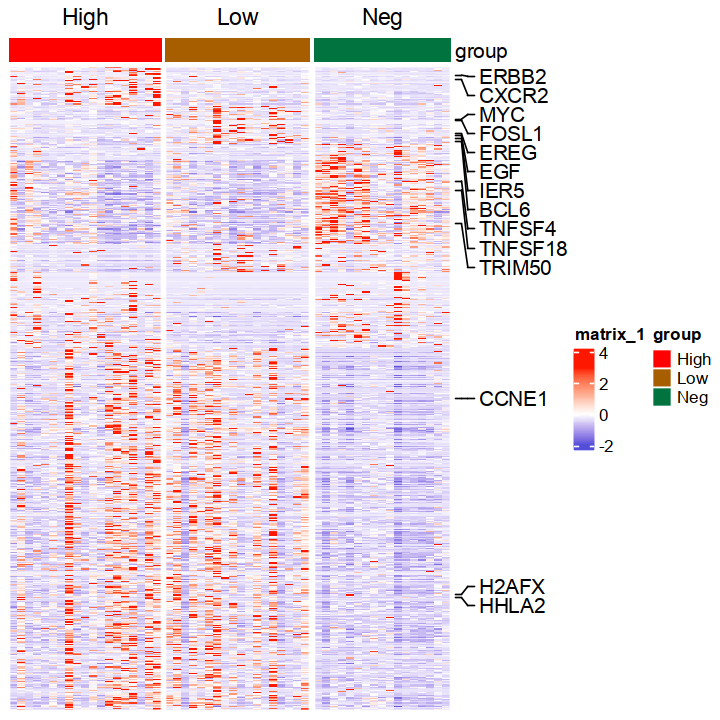

In [66]:
options(repr.plot.height=6,repr.plot.width=6)
p

In [209]:
pdf(file = "TumorOnly.Heatmap.pdf",width = 6,height = 6)
options(repr.plot.height=6,repr.plot.width=6)
p
dev.off()

png 
  2

## GO annotation

In [67]:
high_genes <- bitr(high_spec %>% filter(category=="High") %>% rownames(),fromType = "ALIAS",toType="ENTREZID", OrgDb="org.Hs.eg.db")
low_genes <- bitr(low_spec %>% filter(category=="Low") %>% rownames(),fromType = "ALIAS",toType="ENTREZID", OrgDb="org.Hs.eg.db")
neg_genes <- bitr(neg_spec %>% filter(category=="negative") %>% rownames(),fromType = "ALIAS",toType="ENTREZID", OrgDb="org.Hs.eg.db")

'select()' returned 1:many mapping between keys and columns

Warning message in bitr(high_spec %>% filter(category == "High") %>% rownames(), :
“5.71% of input gene IDs are fail to map...”
'select()' returned 1:many mapping between keys and columns

Warning message in bitr(low_spec %>% filter(category == "Low") %>% rownames(), fromType = "ALIAS", :
“2.94% of input gene IDs are fail to map...”
'select()' returned 1:many mapping between keys and columns

Warning message in bitr(neg_spec %>% filter(category == "negative") %>% rownames(), :
“3.37% of input gene IDs are fail to map...”


In [68]:
DoGO <- function(gene){
    data_go <- enrichGO(gene = 
                             gene$ENTREZID,
                             OrgDb = org.Hs.eg.db,
                             ont = "All",
                             pAdjustMethod = "BH",
                             qvalueCutoff = 0.05,
                             pvalueCutoff = 0.05,
                             readable = TRUE
                        )
    return(data_go)
}

In [69]:
DoGO2 <- function(gene){
    data_go <- enrichGO(gene = 
                             gene$ENTREZID,
                             OrgDb = org.Hs.eg.db,
                             ont = "All",
                             pAdjustMethod = "BH",
                             qvalueCutoff = 1,
                             pvalueCutoff = 1,
                             readable = TRUE
                        )
    return(data_go)
}

In [70]:
high_go <- DoGO(high_genes)
low_go <- DoGO(low_genes)
neg_go <- DoGO(neg_genes)

## Inflamation

In [71]:
inflammation_genes <- c("PSMB10", "HLA-DQA1", "HLA-DRB1","CMKLR1", "HLA-E", "NKG7", "CD8A", "CCL5", "CXCL9",
                        "CD27", "CXCR6", "IDO1","STAT1", "TIGIT", "LAG3", "CD274", "PDCD1LG2", "CD276","CCL5")

In [88]:
length(unique(inflammation_genes))

[1] 18

In [72]:
group %>% filter(group=="High") %>% rownames() -> high_names
group %>% filter(group=="Low") %>% rownames() -> low_names
group %>% filter(group=="negative") %>% rownames() -> neg_names

In [73]:
data_Tumor_tpm[inflammation_genes,high_names] %>% colMeans() -> infla_high

In [74]:
data_Tumor_tpm[inflammation_genes,low_names] %>% colMeans() -> infla_low

In [75]:
data_Tumor_tpm[inflammation_genes,neg_names] %>% colMeans() -> infla_neg

In [76]:
TIS_data <- data.frame(TIS = c(infla_high,infla_low,infla_neg),group = c(rep("High",19),rep("Low",18),rep("Neg",17)))

In [77]:
head(TIS_data)

,TIS,group
,<dbl>,<chr>
9DW0073,158.53801,High
9DW0079,73.19996,High
9DW0076,107.55226,High
9DW0126,118.75552,High
9DW0169,92.60689,High
9DW0192,152.25607,High


In [78]:
compare <- list(c("High","Low"),c("Low","Neg"),c("Low","Neg"))

In [79]:
p_tumor_box <- ggboxplot(TIS_data,x="group",y="TIS",add="jitter",add.params=list(shape=21, fill="orange", size=3)
         )+geom_signif(comparisons = compare,step_increase = 0.1,map_signif_level = F,test = t.test
                      )+ylab("Proportion")

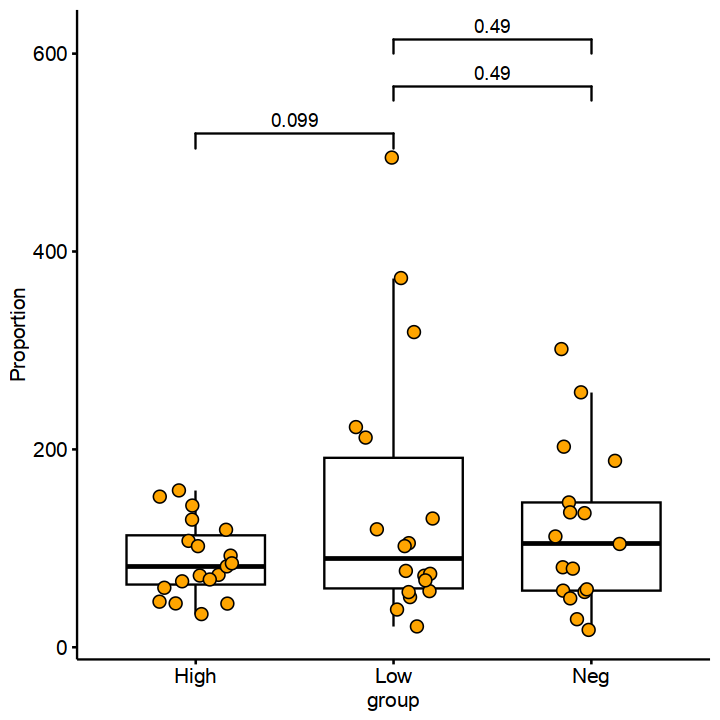

In [82]:
p_tumor_box

In [81]:
save.image("RNAseq.tumor.Rdata")